In [1]:
import os
import glob
import re
import json
import yaml
import pandas as pd
pd.set_option('max_rows', 20)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from contrastive.utils.models_database import get_subdirs, get_path2logs, get_loss, post_process_bdd_models

In [2]:
paths = glob.glob("/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/pretrained_UKB/ACCpatterns/same_side/16-36-40_0" + "/*_results")
path = paths[0]
print(path)

#regex = "/(?<=/).*?(?=_results)"
regex = r"[^/]*_results"

matches = re.findall(regex, path)
for match in matches:
    print(match)

/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/pretrained_UKB/ACCpatterns/same_side/16-36-40_0/cingulate_ACCpatterns_results
cingulate_ACCpatterns_results


In [3]:
def get_test_dataset(dir_path):
    regex = r"[^/]*_results"
    matches = re.findall(regex, path)
    match = matches[0]
    return match[:-8]

get_test_dataset(path)

'cingulate_ACCpatterns'

In [4]:
def process_supervised_model(model_path, verbose=False):
    # generate a dictionnary with the model's parameters and performances
    model_dict = {}
    model_dict['model_path'] = model_path

    # read performances
    results_dirs = glob.glob(model_path + "/*_results")
    for results_dir in results_dirs:
        dataset_name = get_test_dataset(results_dir)
        with open(results_dir + "/test_results.json", 'r') as file:
            values = json.load(file)
            #decomposed_values = {f'{dataset_name}_test_auc': values['test_auc']}
            decomposed_values = {'test_auc': values['test_auc']}
            if 'test_intra_auc' in values.keys(): 
                decomposed_values['test_intra_auc'] = values['test_intra_auc']
            model_dict.update(decomposed_values)
        with open(results_dir + "/test_results_best_model.json", 'r') as file:
            values = json.load(file)
            #decomposed_values = {f'{dataset_name}_test_auc_best_model': values['test_auc']}
            decomposed_values = {'test_auc_best_model': values['test_auc']}
            if 'test_intra_auc' in values.keys(): 
                decomposed_values['test_intra_auc_best_model'] = values['test_intra_auc']
            model_dict.update(decomposed_values)
    
    # read parameters
    with open(model_path+'/partial_config.yaml', 'r') as file2:
        partial_config = yaml.load(file2, Loader=yaml.FullLoader)
        model_dict.update(partial_config)
    
    # compute losses if necessary
    log_path = get_path2logs(model_path)
    if not os.path.exists(os.path.join(log_path, "final_losses.json")):
        if verbose:
            print(f"Get the losses for {model_path}.")
        get_loss(model_path, save=True, verbose=verbose)
    
    # get the final losses
    with open(os.path.join(log_path, "final_losses.json"), 'r') as file3:
        losses = json.load(file3)
        model_dict.update(losses)

    return model_dict

In [5]:
# test
process_supervised_model("/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/pretrained_UKB/ACCpatterns/same_side/16-36-40_0")

{'model_path': '/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/pretrained_UKB/ACCpatterns/same_side/16-36-40_0',
 'test_auc': 0.7710233029381965,
 'test_auc_best_model': 0.7669706180344478,
 'backbone_name': 'convnet',
 'batch_size': 16,
 'checkerboard_size': 4,
 'dataset_name': 'cingulate_ACCpatterns',
 'depth_decoder': 3,
 'drop_rate': 0.05,
 'early_stopping_patience': 25,
 'environment': 'not_brainvisa',
 'fill_value': 0,
 'foldlabel': True,
 'input_size': '(1, 20, 42, 38)',
 'keep_bottom': True,
 'lr': 0.001,
 'max_angle': 6,
 'max_epochs': 100,
 'mode': 'classifier',
 'model': 'SimCLR_supervised',
 'n_max': 1099,
 'nb_subjects': -1,
 'num_representation_features': 10,
 'partition': [0.9, 0.1],
 'percentage': 0,
 'pin_mem': True,
 'pretrained_model_path': '/neurospin/dico/jchavas/Runs/59_analysis_ukbiobank/Output/trained_on_ukbiobank/chosen_model/chosen_model/logs/default/version_0/checkpoints/epoch=250-step=297685.ckpt',
 'proportion_pure_contrastive': 0.0,
 'random_st

In [6]:
def generate_bdd_supervised_models(folders, bdd_models, visited,
                                   verbose=True, best_model=True):
    # depth first exploration of folders to treat all the models in it
    
    if verbose:
        print("Start", len(folders), len(bdd_models))

    while folders != []:
        # remove folders already treated
        folders = [folder for folder in folders if folder not in visited]
        
        # condition as folders can be emptied by the previous line
        if folders != []:
            dir_path = folders.pop()
            visited.append(dir_path)
            
            # checks if directory
            if os.path.isdir(dir_path):
                # check if directory associated to a model
                if os.path.exists(dir_path+'/.hydra/config.yaml'):
                    print("Treating", dir_path)
                    # check if values and parameters computed for the model
                    if glob.glob(dir_path + "/*_results") != []:
                        model_dict = process_supervised_model(dir_path)
                        bdd_models.append(model_dict)


                        if verbose:
                            print("End model", len(folders), len(bdd_models))

                    else:
                        print(f"Model has not been evaluated yet.")

                else:
                    print(f"{dir_path} not associated to a model. Continue")
                    new_dirs = get_subdirs(dir_path)
                    folders.extend(new_dirs)
                    # remove folders already treated
                    folders = [folder for folder in folders if folder not in visited]
                    if verbose:
                        print("End recursive", len(folders), len(bdd_models))
                    
                    generate_bdd_supervised_models(folders, bdd_models, visited,
                                        verbose=verbose, best_model=best_model)
            
            else:
                print(f"{dir_path} is a file. Continue.")
                if verbose:
                    print("End file", len(bdd_models))

In [7]:
folders = ["/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised"]
bdd = []
visited = []

generate_bdd_supervised_models(folders, bdd, visited)

bdd = pd.DataFrame(bdd)

bdd = post_process_bdd_models(bdd, hard_remove=['partition', 'patch_size', 'n_max'])

Start 1 0
/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised not associated to a model. Continue
End recursive 3 0
Start 3 0
/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns not associated to a model. Continue
End recursive 4 0
Start 4 0
/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns/R not associated to a model. Continue
End recursive 21 0
Start 21 0
Treating /neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns/R/10-35-58_3
End model 20 1
Treating /neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns/R/10-04-09_0
End model 19 2
Treating /neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns/R/09-46-31_2
End model 18 3
Treating /neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns/R/10-35-58_1
End model 17 4
Treating /neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns/R/09-14-24_3
End model 16 5
Treating /neurospin/dico/agaudin/Runs/09_new_repo/Out

In [8]:
bdd['side'] = np.where(bdd.dataset_name.str.contains('left'), 'left', 'right')
bdd['pretrained'] = np.where(bdd.model_path.str.contains('pretrained'), True, False)
bdd

,model_path,test_auc,test_auc_best_model,dataset_name,early_stopping_patience,foldlabel,input_size,lr,model,percentage,...,train_val_csv_file,with_labels,train_loss,val_loss,both,resize,test_intra_auc,test_intra_auc_best_model,side,pretrained
0,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.712077,0.812560,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,0.0,...,/neurospin/dico/data/deep_folding/current/data...,True,0.130985,3.214311,False,False,NaN,NaN,left,False
1,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.794203,0.741063,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,10.0,...,/neurospin/dico/data/deep_folding/current/data...,True,0.149218,3.638716,False,False,NaN,NaN,left,False
2,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.767150,0.817391,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,20.0,...,/neurospin/dico/data/deep_folding/current/data...,True,0.384017,2.198195,False,False,NaN,NaN,left,False
3,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.842512,0.764251,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,30.0,...,/neurospin/dico/data/deep_folding/current/data...,True,0.731070,1.360693,False,False,NaN,NaN,left,False
4,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.843478,0.782609,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,40.0,...,/neurospin/dico/data/deep_folding/current/data...,True,1.002066,1.402734,False,False,NaN,NaN,left,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.478157,0.479589,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0050,SimCLR_supervised,NaN,...,NaN,True,1.305833,1.456876,NaN,NaN,0.687788,0.689804,right,False
45,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.485796,0.405825,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0050,SimCLR_supervised,NaN,...,NaN,True,1.204426,1.461519,NaN,NaN,0.644009,0.637385,right,False
46,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.467653,0.406063,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0050,SimCLR_supervised,NaN,...,NaN,True,1.325698,1.416836,NaN,NaN,0.685196,0.626152,right,False
47,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.472428,0.477680,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0050,SimCLR_supervised,NaN,...,NaN,True,1.332289,1.381910,NaN,NaN,0.687788,0.692684,right,False


# Analysis

## Schiz

In [10]:
schiz_bdd = bdd[bdd.dataset_name.str.contains("schiz")]
schiz_bdd

,model_path,test_auc,test_auc_best_model,dataset_name,early_stopping_patience,foldlabel,input_size,lr,model,percentage,...,sigma_labels,temperature_supervised,train_val_csv_file,with_labels,train_loss,val_loss,test_intra_auc,test_intra_auc_best_model,side,pretrained
23,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.470995,0.504655,cingulate_schiz_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,...,2.0,0.3,NaN,True,0.710044,2.399487,0.517569,0.509217,left,False
24,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.567200,0.450943,cingulate_schiz_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,...,2.0,0.3,NaN,True,0.979890,1.732319,0.507776,0.623560,left,False
25,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.484125,0.487228,cingulate_schiz_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,...,2.0,0.3,NaN,True,1.308859,1.639801,0.637385,0.591302,left,False
26,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.455717,0.472667,cingulate_schiz_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,...,2.0,0.3,NaN,True,1.317068,1.368463,0.659850,0.670219,left,False
27,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.443065,0.423251,cingulate_schiz_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,...,2.0,0.3,NaN,True,1.329581,1.391745,0.668491,0.682604,left,False
28,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.555264,0.533302,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0010,SimCLR_supervised,NaN,...,2.0,0.3,NaN,True,0.146675,3.901304,0.550115,0.608295,right,False
29,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.512772,0.506326,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0010,SimCLR_supervised,NaN,...,2.0,0.3,NaN,True,0.836767,1.814683,0.564516,0.572005,right,False
30,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.501313,0.457388,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0010,SimCLR_supervised,NaN,...,2.0,0.3,NaN,True,0.797583,1.987188,0.583525,0.611751,right,False
31,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.488661,0.440201,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0010,SimCLR_supervised,NaN,...,2.0,0.3,NaN,True,1.024020,1.814168,0.566244,0.572581,right,False
32,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.502268,0.458582,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0010,SimCLR_supervised,NaN,...,2.0,0.3,NaN,True,1.042204,1.726259,0.547235,0.563076,right,False


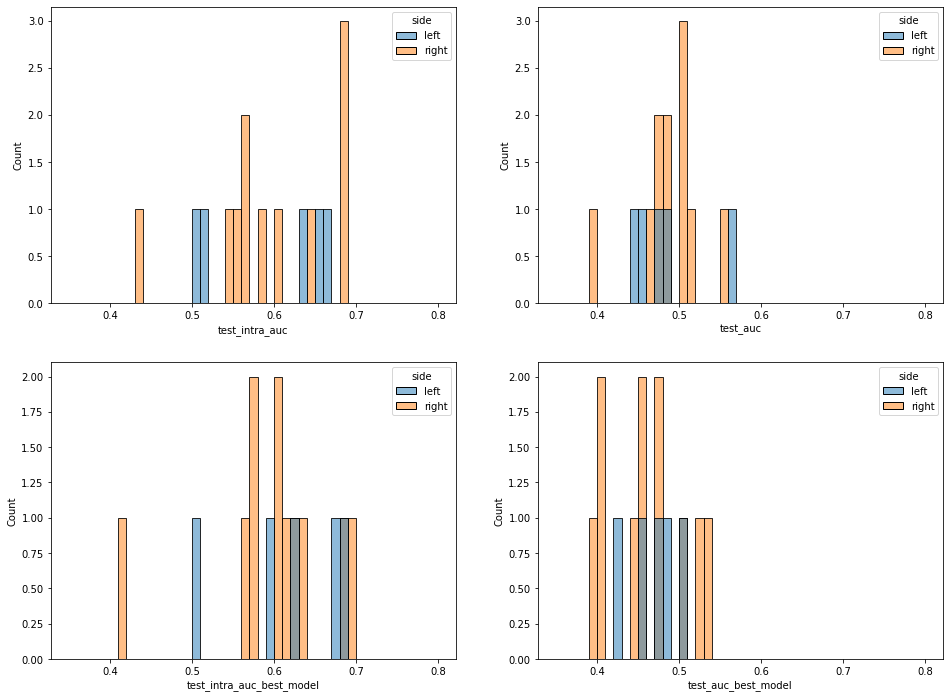

In [11]:
bins = np.arange(0.35, 0.8, 0.01)

plt.figure(figsize=(16,12))

plt.subplot(221)
sns.histplot(schiz_bdd, x='test_intra_auc', hue='side', bins=bins)
plt.subplot(222)
sns.histplot(schiz_bdd, x='test_auc', hue='side', bins=bins)
plt.subplot(223)
sns.histplot(schiz_bdd, x='test_intra_auc_best_model', hue='side', bins=bins)
plt.subplot(224)
sns.histplot(schiz_bdd, x='test_auc_best_model', hue='side', bins=bins)
plt.show()

## ACCpatterns

In [9]:
ACC_bdd = bdd[bdd.dataset_name.str.contains("ACC")]
ACC_bdd

,model_path,test_auc,test_auc_best_model,dataset_name,early_stopping_patience,foldlabel,input_size,lr,model,percentage,...,train_val_csv_file,with_labels,train_loss,val_loss,both,resize,test_intra_auc,test_intra_auc_best_model,side,pretrained
0,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.712077,0.812560,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.005,SimCLR_supervised,0.0,...,/neurospin/dico/data/deep_folding/current/data...,True,0.130985,3.214311,False,False,NaN,NaN,left,False
1,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.794203,0.741063,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.005,SimCLR_supervised,10.0,...,/neurospin/dico/data/deep_folding/current/data...,True,0.149218,3.638716,False,False,NaN,NaN,left,False
2,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.767150,0.817391,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.005,SimCLR_supervised,20.0,...,/neurospin/dico/data/deep_folding/current/data...,True,0.384017,2.198195,False,False,NaN,NaN,left,False
3,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.842512,0.764251,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.005,SimCLR_supervised,30.0,...,/neurospin/dico/data/deep_folding/current/data...,True,0.731070,1.360693,False,False,NaN,NaN,left,False
4,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.843478,0.782609,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.005,SimCLR_supervised,40.0,...,/neurospin/dico/data/deep_folding/current/data...,True,1.002066,1.402734,False,False,NaN,NaN,left,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.771023,0.766971,cingulate_ACCpatterns,25,True,"(1, 20, 42, 38)",0.001,SimCLR_supervised,0.0,...,/neurospin/dico/data/deep_folding/current/data...,True,0.003701,2.197386,NaN,NaN,NaN,NaN,right,True
29,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.758865,0.739615,cingulate_ACCpatterns,25,True,"(1, 20, 42, 38)",0.001,SimCLR_supervised,10.0,...,/neurospin/dico/data/deep_folding/current/data...,True,0.022342,1.370843,NaN,NaN,NaN,NaN,right,True
30,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.722391,0.738602,cingulate_ACCpatterns,25,True,"(1, 20, 42, 38)",0.001,SimCLR_supervised,20.0,...,/neurospin/dico/data/deep_folding/current/data...,True,0.030046,2.936572,NaN,NaN,NaN,NaN,right,True
31,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.807497,0.744681,cingulate_ACCpatterns,25,True,"(1, 20, 42, 38)",0.001,SimCLR_supervised,30.0,...,/neurospin/dico/data/deep_folding/current/data...,True,0.005959,2.806764,NaN,NaN,NaN,NaN,right,True


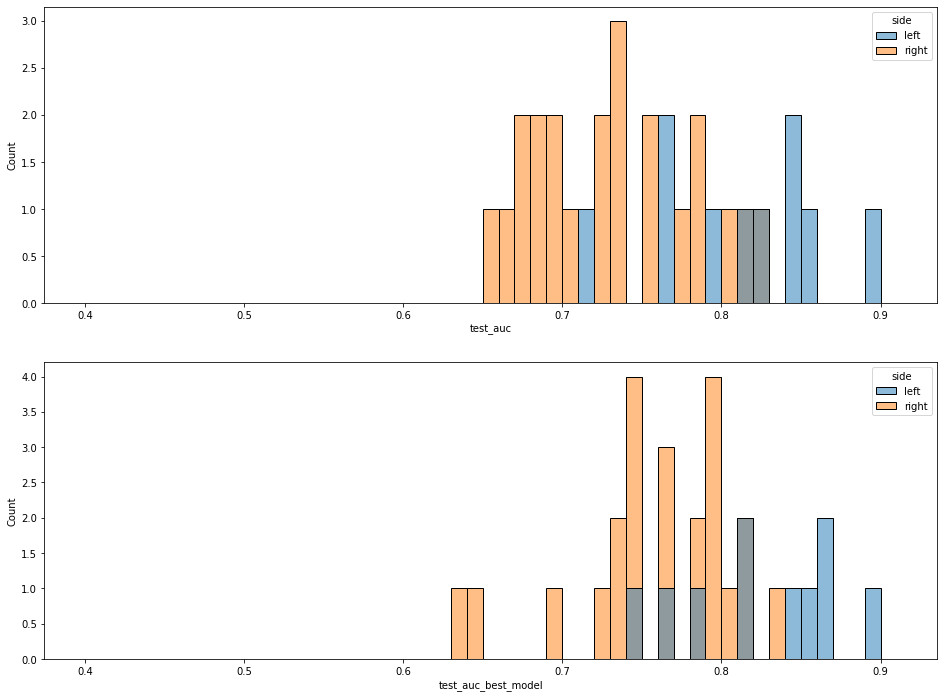

In [19]:
bins = np.arange(0.4, 0.92, 0.01)

plt.figure(figsize=(16,12))

plt.subplot(211)
sns.histplot(ACC_bdd, x='test_auc', hue='side', bins=bins)
plt.subplot(212)
sns.histplot(ACC_bdd, x='test_auc_best_model', hue='side', bins=bins)

plt.show()

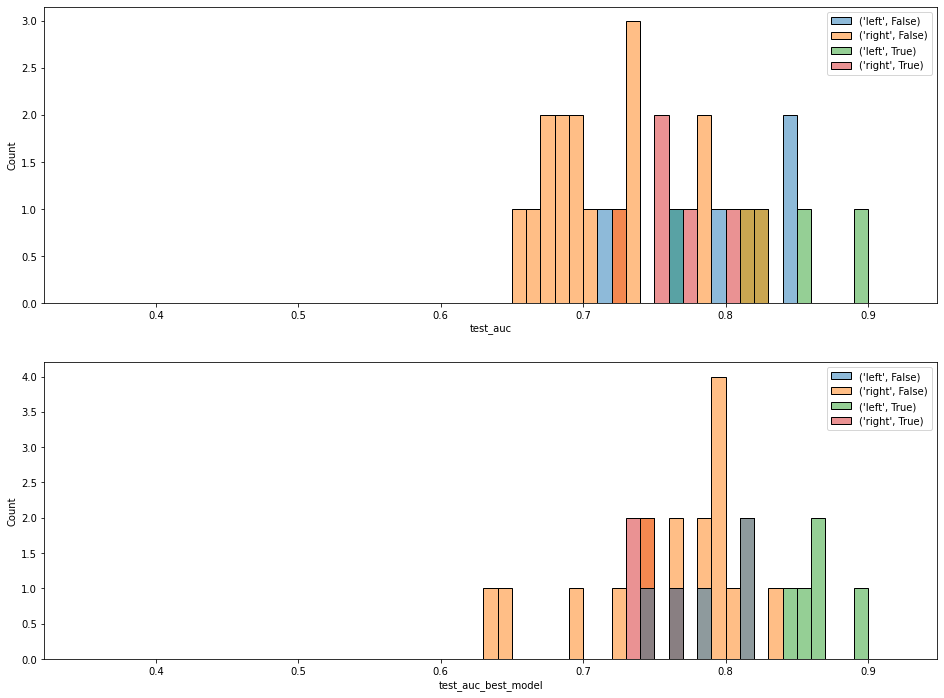

In [18]:
bins = np.arange(0.35, 0.92, 0.01)

plt.figure(figsize=(16,12))

plt.subplot(211)
sns.histplot(ACC_bdd, x='test_auc', hue=ACC_bdd[['side', 'pretrained']].apply(tuple, axis=1), bins=bins)
plt.subplot(212)
sns.histplot(ACC_bdd, x='test_auc_best_model', hue=ACC_bdd[['side', 'pretrained']].apply(tuple, axis=1), bins=bins)

plt.show()

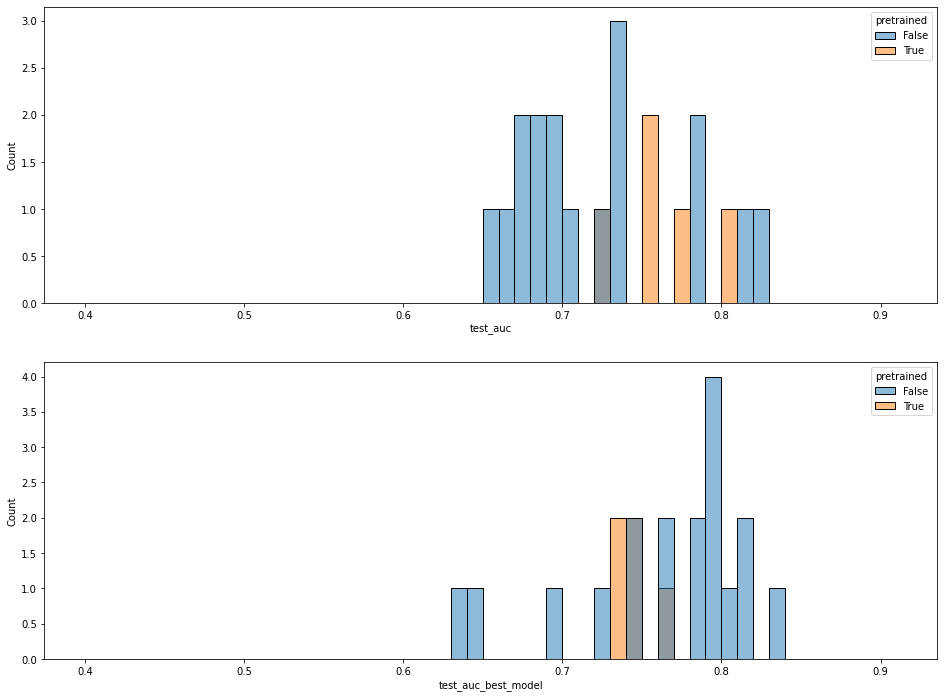

In [17]:
bins = np.arange(0.4, 0.92, 0.01)

plt.figure(figsize=(16,12))

plt.subplot(211)
sns.histplot(ACC_bdd[ACC_bdd.side == 'right'], x='test_auc', hue='pretrained', bins=bins)
plt.subplot(212)
sns.histplot(ACC_bdd[ACC_bdd.side == 'right'], x='test_auc_best_model', hue='pretrained', bins=bins)

plt.show()

<AxesSubplot:xlabel='lr', ylabel='test_auc_best_model'>

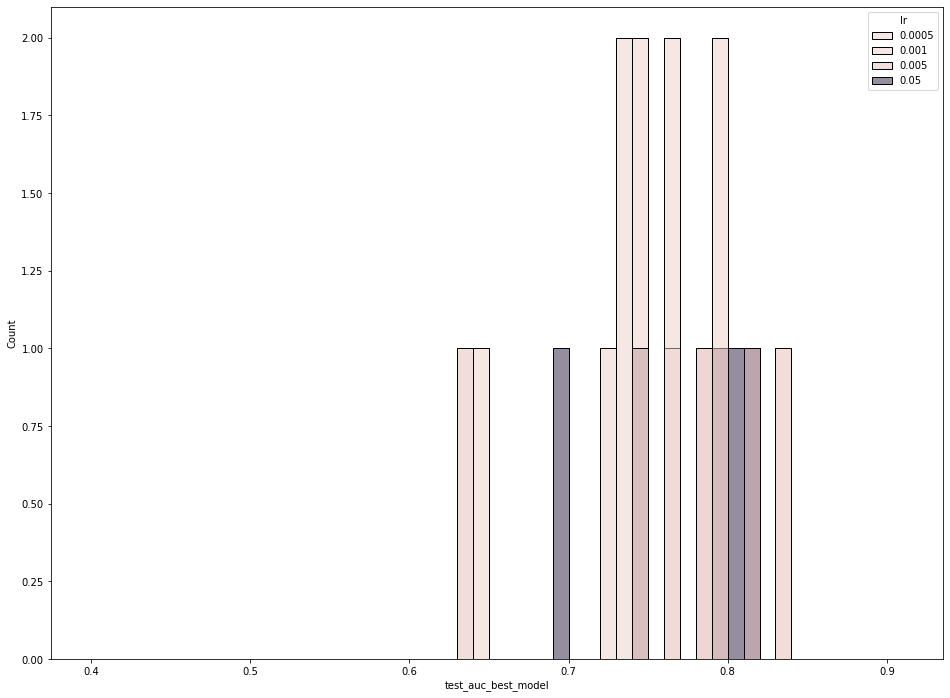

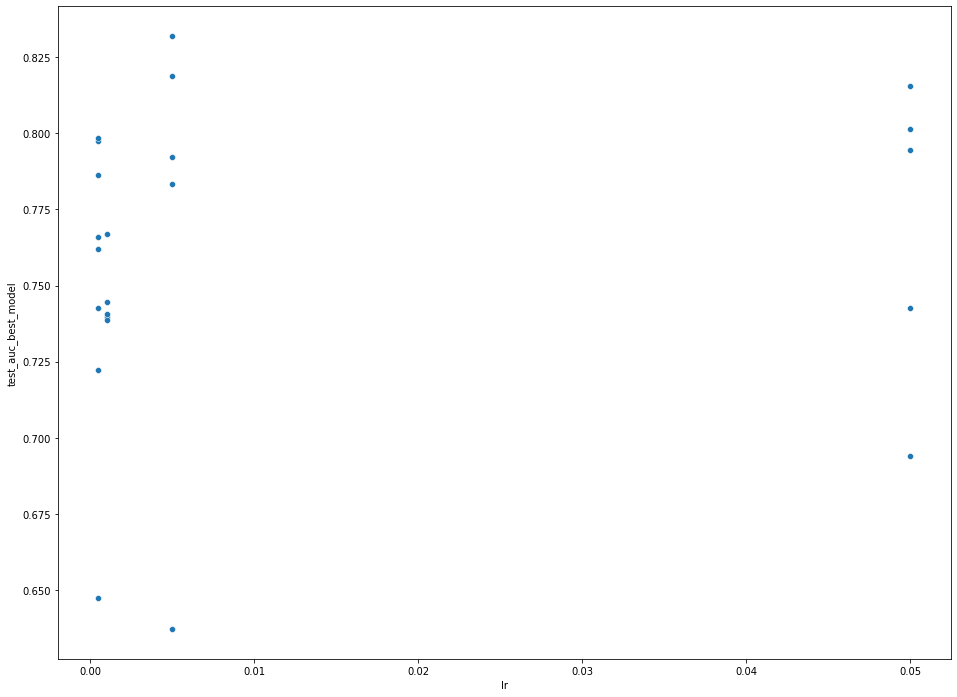

In [29]:
plt.figure(figsize=(16,12))
sns.histplot(ACC_bdd[ACC_bdd.side == 'right'], x='test_auc_best_model', hue='lr', bins=bins)

plt.figure(figsize=(16,12))
sns.scatterplot(data=ACC_bdd[ACC_bdd.side == 'right'], x='lr', y='test_auc_best_model')

In [26]:
ACC_bdd[ACC_bdd.side == 'left'].lr.unique()

array([0.005])

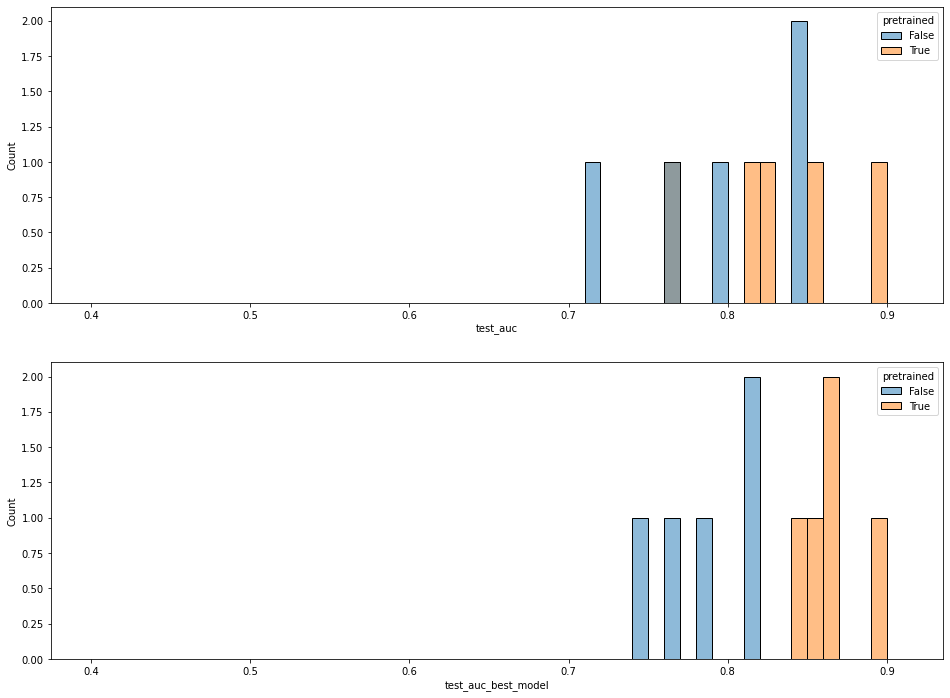

In [16]:
bins = np.arange(0.4, 0.92, 0.01)

plt.figure(figsize=(16,12))

plt.subplot(211)
sns.histplot(ACC_bdd[ACC_bdd.side == 'left'], x='test_auc', hue='pretrained', bins=bins)
plt.subplot(212)
sns.histplot(ACC_bdd[ACC_bdd.side == 'left'], x='test_auc_best_model', hue='pretrained', bins=bins)

plt.title("Pretraining effect on the left side (opposite)")

plt.show()

## Common analysis

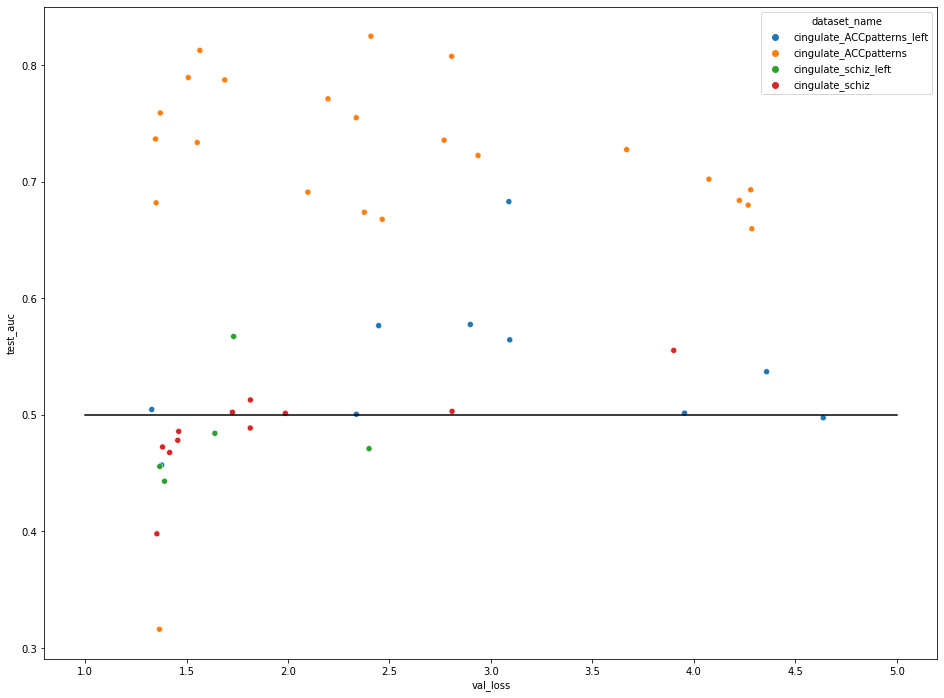

In [44]:
plt.figure(figsize=(16,12))
sns.scatterplot(data=bdd, x='val_loss', y='test_auc', hue='dataset_name')
plt.plot([1,5], [0.5,0.5], c='black')
plt.show()

In [20]:
from contrastive.utils.config import get_config_diff

get_config_diff("/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns/R")